# Непараметрическая регрессия  

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_csv('datasets/auto_insurance_sweden.csv', names=['X', 'Y'])
data = np.array(dataset.X)
target = np.array(dataset.Y)

In [3]:
class Regression:
    
    def __init__(self, h=10, kernel='gaussian', lowess=False, lowess_kernel='quartic'):
        self._h = h
        self._kernel = getattr(self, '_' + kernel)
        self._data = []
        self._target = []
        self._lws = lowess
        self._deltas = np.array([])
        self._lws_kernel = getattr(self, '_' + lowess_kernel)
        
    def _dist(self, x1: float, x2: np.ndarray) -> np.ndarray: 
        return abs(x1 - x2)
    
    def _rect(self, u):
        return 0.5*(abs(u) <= 1)
    
    def _gaussian(self, u: np.ndarray) -> np.ndarray:
        return 1/np.sqrt(2*np.pi)*np.power(np.e, -0.5*u**2)
    
    def _quartic(self, u: np.ndarray) -> np.ndarray:
        return (1-u**2)**2*(abs(u) <= 1)
        
    def _lowess_fit(self):
        for i in range(3):
            y_est = np.array([self.predict(val) for val in self._data])
            eps = abs(y_est - self._target)
            new_deltas = self._lws_kernel(eps/(6*np.median(eps)))
            if abs(sum(self._deltas) - sum(new_deltas)) <= 1e-3:
                break
            self._deltas = new_deltas
    
    def sse(self):
        return sum([(self.predict(self._data[i])-self._target[i])**2 for i in range(self._data.shape[0])])
        
    def fit(self, data, target):
        self._sc_data = StandardScaler()
        self._sc_target = StandardScaler()
        self._data = data
        self._target = target
        self._deltas = np.ones(self._target.shape[0])
        if self._lws:
            self._lowess_fit()
                  
    def predict(self, x: float) -> np.ndarray:
        r = self._dist(x, self._data) / self._h
        first = sum(self._target*self._deltas*self._kernel(r))
        second = sum(self._kernel(r))
        res = first / second
        return res

## Регрессия с гауссовским ядом

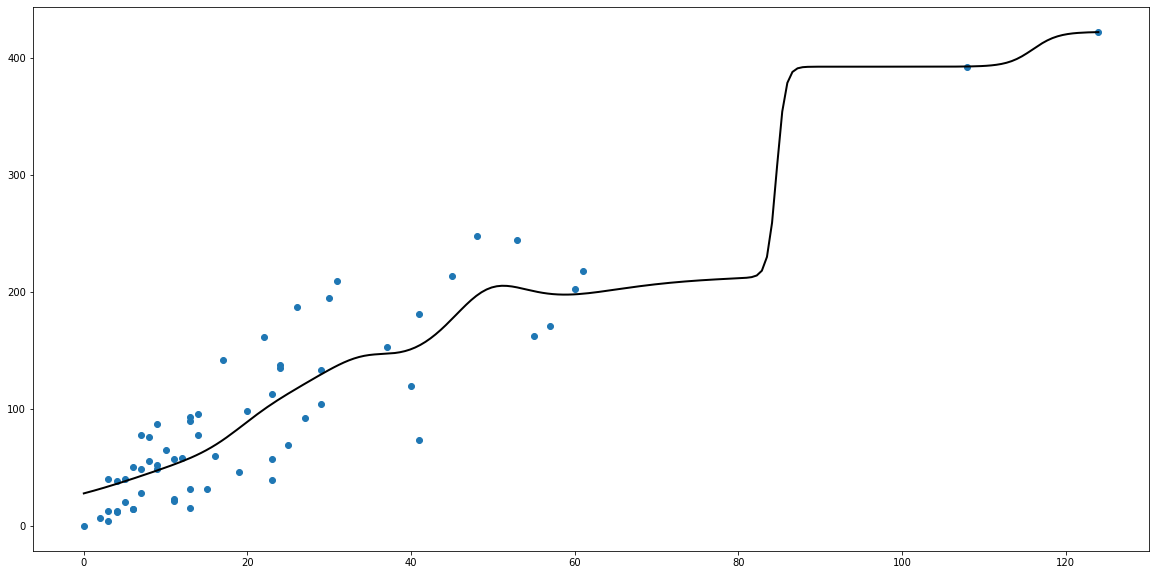

SSE: 71134.081


In [4]:
values = np.linspace(np.min(data), np.max(data), num=200)

reg = Regression(h=5, kernel='gaussian')
reg.fit(data, target)
results = np.array([reg.predict(val) for val in values])
fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(data, target)
ax.plot(values, results, color='black', linewidth=2)

plt.show()
print('SSE: %.3f' % reg.sse())

## Регрессия с квартическим ядром

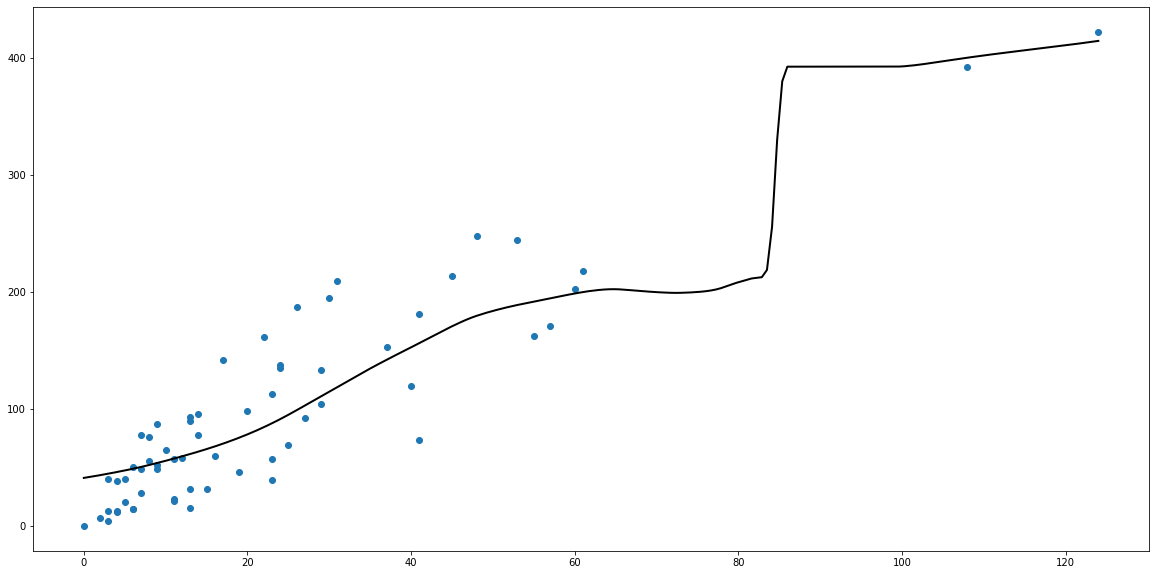

SSE: 88269.125


In [5]:
values = np.linspace(np.min(data), np.max(data), num=200)
reg = Regression(h=25, kernel='quartic')
reg.fit(data, target)
results = np.array([reg.predict(val) for val in values])
fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(data, target)
ax.plot(values, results, color='black', linewidth=2)

plt.show()
print('SSE: %.3f' % reg.sse())

# LOWESS

In [6]:
new_data = np.append(data, [40, 35, 37, 36, 38, 39, 36, 40, 35, 37])
new_target = np.append(target, [400, 350, 350, 390, 340, 370, 380, 350, 380, 370])
sc = StandardScaler()
new_data = new_data.reshape((new_data.shape[0], 1))
new_data = sc.fit_transform(new_data)
new_target = new_target.reshape((new_target.shape[0], 1))
new_target = sc.fit_transform(new_target)
new_data = np.ravel(new_data)
new_target = np.ravel(new_target)

SSE for unsmoothed: 14.621
SSE for LOWESS: 39.231


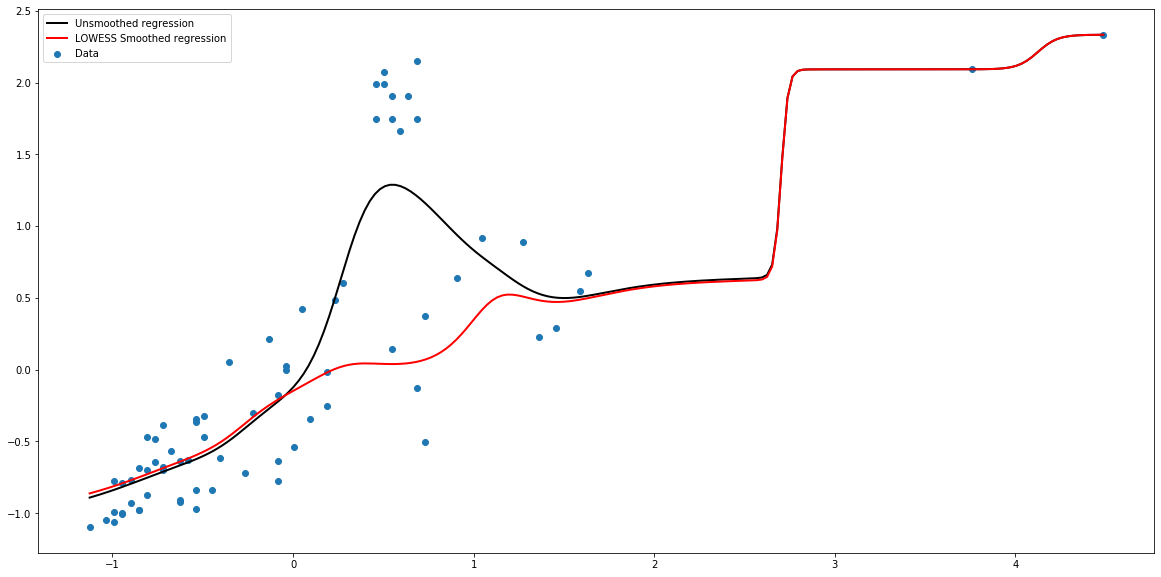

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(new_data, new_target, label='Data')

values = np.linspace(np.min(new_data), np.max(new_data), num=200)
reg = Regression(h=0.2, kernel='gaussian')
reg.fit(new_data, new_target)
results = np.array([reg.predict(val) for val in values])
ax.plot(values, results, color='black', linewidth=2, label='Unsmoothed regression')
print('SSE for unsmoothed: %.3f' % reg.sse())

reg = Regression(h=0.2, kernel='gaussian', lowess=True, lowess_kernel='quartic')
reg.fit(new_data, new_target)
results = np.array([reg.predict(val) for val in values])
ax.plot(values, results, color='red', linewidth=2, label='LOWESS Smoothed regression')
print('SSE for LOWESS: %.3f' % reg.sse())

ax.legend(loc='upper left')
plt.show()